In [1]:
import nilearn
import nibabel as nib

In [2]:
from nilearn import datasets, image
from nilearn.maskers import NiftiMasker
from nilearn.plotting import plot_epi, plot_roi, show

In [3]:
from nilearn.datasets import (load_mni152_template,)
template = load_mni152_template(resolution=3)


In [4]:
from nilearn.image import resample_to_img
stat_img = nib.load(r"/mnt/k/Abide Dataset/dataset/ABIDEII-EMC_1/29913/session_1/rest_1/rest.nii")
resampled_stat_img = resample_to_img(stat_img, template, force_resample=True, interpolation = 'linear')

In [5]:
# First load the original t-map in memory:
from nilearn.image import load_img

tmap_img = load_img(stat_img)

original_shape = tmap_img.shape
original_affine = tmap_img.affine

resampled_shape = resampled_stat_img.shape
resampled_affine = resampled_stat_img.affine

template_img = load_img(template)
template_shape = template_img.shape
template_affine = template_img.affine
print(
    f"""Shape comparison:
- Original t-map image shape : {original_shape}
- Resampled t-map image shape: {resampled_shape}
- Template image shape       : {template_shape}
"""
)

print(
    f"""Affine comparison:
- Original t-map image affine :
 {original_affine}
- Resampled t-map image affine:
 {resampled_affine}
- Template image affine       :
 {template_affine}
"""
)

Shape comparison:
- Original t-map image shape : (64, 64, 37, 160)
- Resampled t-map image shape: (67, 79, 64, 160)
- Template image shape       : (67, 79, 64)

Affine comparison:
- Original t-map image affine :
 [[ -3.59380007  -0.          -0.         113.20470428]
 [ -0.           3.59380007  -0.         -68.93740845]
 [  0.           0.           4.          -8.58799744]
 [  0.           0.           0.           1.        ]]
- Resampled t-map image affine:
 [[   3.    0.    0.  -98.]
 [   0.    3.    0. -134.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
- Template image affine       :
 [[   3.    0.    0.  -98.]
 [   0.    3.    0. -134.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]



In [6]:
import ants
import numpy as np

# Load the 4D fMRI image and MNI152 template
fmri_image = nib.load('/mnt/k/Abide Dataset/dataset/transfer - Copy - Copy/ABIDEII-EMC_1/29913/session_1/rest_1/rest.nii')
mni_template = load_mni152_template(resolution=3)

# Placeholder for registered volumes
registered_volumes = []

# Iterate over each timepoint (3D volume) in the 4D fMRI image
for time_idx in range(fmri_image.shape[-1]):
    # Extract the 3D volume for the current timestamp
    fmri_volume = nib.Nifti1Image(fmri_image.dataobj[..., time_idx], affine=fmri_image.affine)
    
    # Resample the 3D volume to match the MNI template resolution
    resampled_volume = resample_to_img(fmri_volume, mni_template)
    
    # Convert the resampled volume to an ANTs image for registration
    resampled_volume_data = np.array(resampled_volume.dataobj)
    resampled_affine = resampled_volume.affine
    ants_volume = ants.from_numpy(resampled_volume_data)
    ants_volume.set_spacing(tuple(np.sqrt(np.sum(resampled_affine[:3, :3] ** 2, axis=0))))
    
    # Convert the MNI template to an ANTs image (if not already done)
    if time_idx == 0:
        mni_template_data = np.array(mni_template.dataobj)
        mni_affine = mni_template.affine
        ants_mni_template = ants.from_numpy(mni_template_data)
        ants_mni_template.set_spacing(tuple(np.sqrt(np.sum(mni_affine[:3, :3] ** 2, axis=0))))
    
    # Register the current volume to the MNI template
    registration_result = ants.registration(fixed=ants_mni_template, moving=ants_volume, type_of_transform='SyN')
    
    # Append the registered volume to the list
    registered_volumes.append(registration_result['warpedmovout'].numpy())

# Stack all registered volumes along the time axis to create a new 4D image
registered_4d_data = np.stack(registered_volumes, axis=-1)
registered_4d_image = nib.Nifti1Image(registered_4d_data, affine=mni_template.affine)



/root/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int16 to float32
  return resample_img(
/root/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int16 to float32
  return resample_img(
/root/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int16 to float32
  return resample_img(
/root/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int16 to float32
  return resample_img(
/root/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int16 to float32
  return resample_img(
/root/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/nilearn/image/resampling.py:756: UserWarning: Casting data from int16 to float32
  return resamp

In [7]:
# affine = resampled_stat_img.affine
# affine[:3, 3] = 0  # Center the image by setting translations to zero

# # Create a new image with the updated affine
# centered_image = nib.Nifti1Image(resampled_stat_img.get_fdata(), affine)

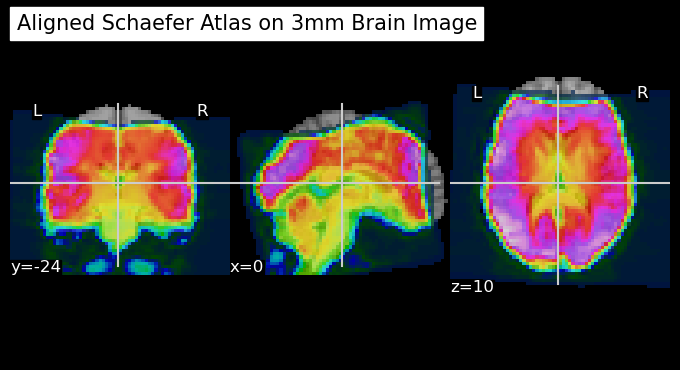

In [8]:
from nilearn import plotting
from nilearn.image import mean_img
image_3d = registered_4d_image.slicer[..., 0]
image_3d_mean = mean_img(registered_4d_image)
# Display the resampled atlas on top of the brain image
plotting.plot_roi(image_3d_mean, bg_img=template_img, title="Aligned Schaefer Atlas on 3mm Brain Image")
plotting.show()


In [9]:




import matplotlib.pyplot as plt

from nilearn import datasets

In [10]:
atlas=nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=1000, yeo_networks=17, resolution_mm=1, data_dir=None, base_url=None, resume=True, verbose=1)
print(f"The atlas contains {len(atlas.labels) - 1} non-overlapping regions")

The atlas contains 999 non-overlapping regions


In [11]:
import numpy as np
from nilearn.image import get_data
unique_regions = np.unique(get_data(atlas.maps))
print(unique_regions)

[   0.    1.    2. ...  998.  999. 1000.]


In [12]:
labels = np.insert(atlas.labels, 0, 'Background')

# Step 4: Convert all labels to strings
labels = [str(label) for label in labels]


In [13]:
from nilearn.maskers import NiftiLabelsMasker


# Instantiate the masker with label image and label values
masker = NiftiLabelsMasker(
    atlas.maps,
    labels=labels,
    standardize="zscore_sample",
)

# Visualize the atlas
# Note that we need to call fit prior to generating the mask
masker.fit()

# At this point, no functional image has been provided to the masker.
# We can still generate a report which can be displayed in a Jupyter
# Notebook, opened in a browser using the .open_in_browser() method,
# or saved to a file using the .save_as_html(output_filepath) method.
report = masker.generate_report()
report

/tmp/ipykernel_2622/2067994970.py:19: UserWarning: No image provided to fit in NiftiLabelsMasker. Plotting ROIs of label image on the MNI152Template for reporting.
  report = masker.generate_report()


In [14]:
masker.fit(registered_4d_image)

# We can again generate a report, but this time, the provided functional
# image is displayed with the ROI of the atlas.
# The report also contains a summary table giving the region sizes in mm3
report = masker.generate_report()
report

In [15]:
# from nilearn.image import index_img

# # Select the first time point (index 0) from the 4D image
# stat_img_3d = index_img(resampled_stat_img, 67)

# # Now use the 3D image for visualization
# from nilearn import plotting

# view = plotting.view_img_on_surf(
#     stat_img_3d,  # Use the extracted 3D image
#     threshold=1.0,  # Adjust the threshold if needed
#     title='Atlas regions on Functional Image (First Time Point)'
# )

# # Display the interactive plot
# view.open_in_browser()


In [16]:
signals = masker.transform(registered_4d_image )
# signals is a 2D matrix, (n_time_points x n_regions)
signals.shape

(160, 1000)

In [17]:
import pandas as pd

# Create a DataFrame from the signals matrix
signals_df = pd.DataFrame(signals)

# Save the DataFrame to a CSV file
output_path = r"csv.csv"  # Adjust the path if needed
signals_df.to_csv(output_path, index=False)

print(f"CSV file saved at: {output_path}")


CSV file saved at: csv.csv


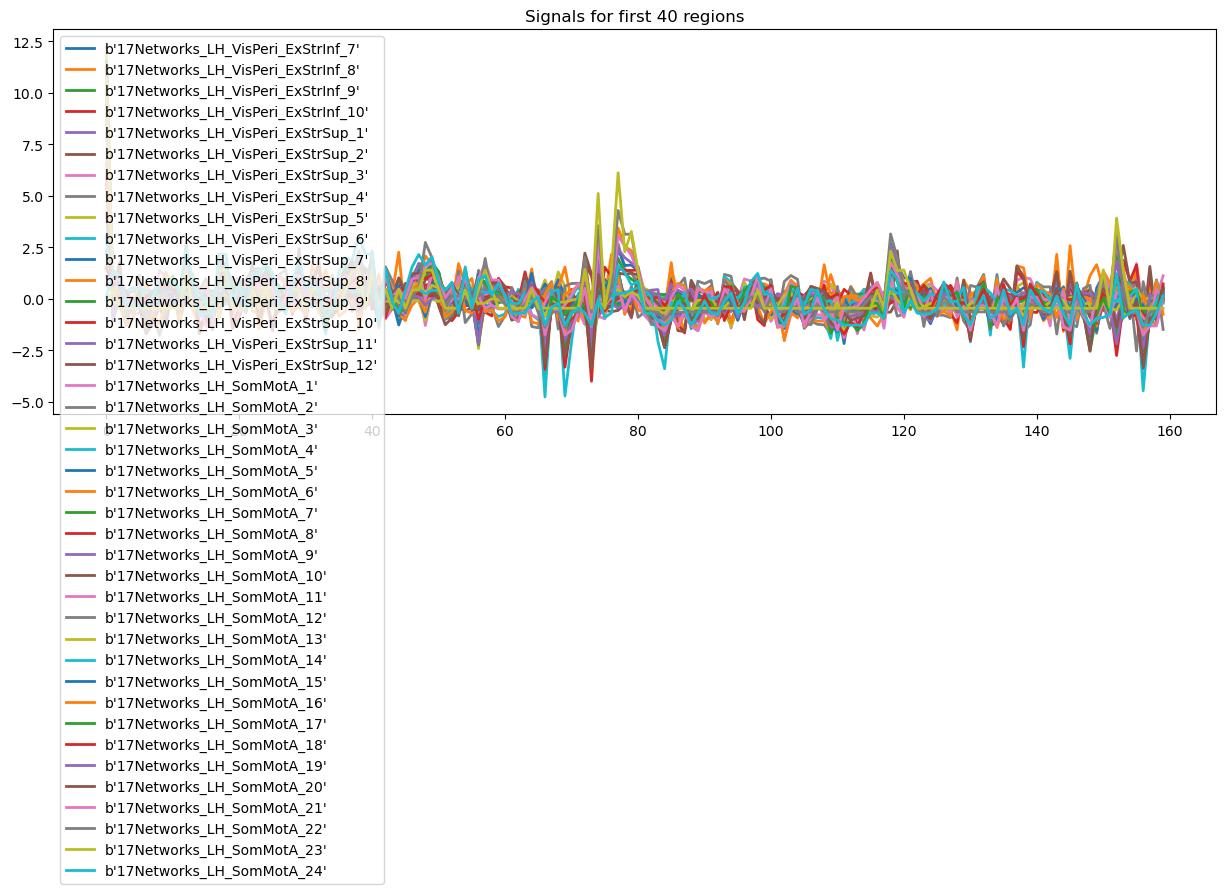

In [18]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for label_idx in range(50,90):
    ax.plot(
        signals[:, label_idx], linewidth=2, label=labels[label_idx + 1]
    )  # 0 is background
ax.legend(loc=2)
ax.set_title("Signals for first 40 regions")
plt.show()